In [12]:
import xarray as xr 
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
from xhistogram.xarray import histogram
import dask.array as da

from dask.distributed import LocalCluster, Client

cluster = LocalCluster(local_directory='/projekt_agmwend/home_rad/Joshua/dask-worker-space', memory_limit='16GB', n_workers=20, threads_per_worker=1, dashboard_address=':8008')
client = Client(cluster)


basepath = '/projekt_agmwend/data/HALO-AC3/05_VELOX_Tools/ml_sea-ice-classification/predictions/'
files = [os.path.join(basepath, f) for f in os.listdir(basepath) if f.endswith('.nc')]
files.sort()

import pandas as pd
import json
plt.rcParams.update(json.load(open('/projekt_agmwend/home_rad/Joshua/MasterArbeit/plot_settings.json')))

filenames = pd.read_csv('/projekt_agmwend/home_rad/Joshua/MasterArbeit/filenames.csv')

MODIS = xr.open_dataset('/projekt_agmwend/data/HALO-AC3/06_satellite/MODIS_ice_surface_temperature_MOD29/MOD29_regridded_merged_v3.nc')
VELOX = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/MasterArbeit/HALO-AC3_VELOX_coarsen_100_v1s.nc')
BACARDI = xr.concat([xr.open_dataset(file) for file in filenames['BACARDI'].tolist()], dim='time')

VELOX['lat'] = ('time', BACARDI.sel(time=VELOX.time, method='nearest')['lat'].values)
VELOX['lon'] = ('time', BACARDI.sel(time=VELOX.time, method='nearest')['lon'].values)


path = '/projekt_agmwend/home_rad/Joshua/radiometer/'
mira_files = [os.path.join(path, file) for file in os.listdir(path) if 'HALO-AC3' in file]
mira_files.sort()

ds_mira_merged = xr.concat([xr.open_dataset(file) for file in mira_files], dim='time')
ds_mira_merged = ds_mira_merged.sortby('uniRadiometer_freq')

grad_ratio_50_37 = ds_mira_merged.sel(uniRadiometer_freq = 50, method='nearest') - ds_mira_merged.sel(uniRadiometer_freq = 37, method='nearest') / ds_mira_merged.sel(uniRadiometer_freq = 50, method='nearest') + ds_mira_merged.sel(uniRadiometer_freq = 37, method='nearest')

#grad_ratio_50_37.TB.plot.hist(bins=100)  

mira_mask = [1 if ratio > 400 else 0 for ratio in grad_ratio_50_37.TB.values]

ds_mira_merged['mask'] = ('time', mira_mask)    
ds_mira_merged['grad_ratio_50_37'] = ('time', grad_ratio_50_37.TB.values)


In [13]:
pred_2d_at_disk = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-03-28_v_0.1_pred.nc', engine='h5netcdf', chunks={'time' : 250, 'x' : 250, 'y' : 250})
ds_tb = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-03-28_v_0.1.nc', engine='h5netcdf', chunks={'time' : 250, 'x' : 250, 'y' : 250})


mira_subset = ds_mira_merged.sel(time=pred_2d_at_disk.time, method='nearest')


In [14]:
basepath = '/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/'
files = [os.path.join(basepath, f) for f in os.listdir(basepath) if f.endswith('pred.nc')]
files.sort()

pred_2d_all = xr.concat([xr.open_dataset(file, engine='h5netcdf', chunks={'time' : 250, 'x' : 250, 'y' : 250}) for file in files], dim='time')

mira_subset = ds_mira_merged.sel(time=pred_2d_all.time)

pred_2d_all['sic'] = 1 - pred_2d_all.label.where(pred_2d_all.label == 1, other=0).mean(dim=['x', 'y'])


files = pd.read_csv('/projekt_agmwend/home_rad/Joshua/MasterArbeit/filenames.csv')['BAHAMAS'].tolist()

ds_bahamas = xr.concat([xr.open_dataset(file) for file in files], dim='tid').rename({'tid' : 'time'})
ds_bahamas = ds_bahamas.assign_coords({'TIME' : ds_bahamas.TIME.values}).rename({'TIME' : 'time'})

ds_bahamas = ds_bahamas.sel(time=pred_2d_all.time, method='nearest') 

In [15]:
ds_modis = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/MasterArbeit/HALO-AC3_VELOX_MODIS_ccval.nc')

In [16]:
pred_2d_all['lat'] = ('time', ds_bahamas.IRS_LAT.values)
pred_2d_all['lon'] = ('time', ds_bahamas.IRS_LON.values)

fram_strait = pred_2d_all.where((pred_2d_all.lat < 81) & (pred_2d_all.lon > -10) )


In [17]:
bins=np.array([0.5, 1.5, 2.5, 3.5, 4.5])
mask = (pred_2d_all.lat < 81) & (pred_2d_all.lon > -10) & (pred_2d_all.lon < 10)
fram_size = mask.sum() * 507 * 635


fram_strait = pred_2d_all.isel(time=mask)

import dask.array as da
most_occuring_cat = histogram(pred_2d_all.label, dim=['x', 'y'], bins=bins).sum(dim='time').persist() / pred_2d_all.label.size
most_occuring_cat_fs = histogram(fram_strait.label, dim=['x', 'y'], bins=bins).sum(dim='time').persist() / fram_strait.label.size

#most_occuring_cat = pred_2d_all.label
#most_occuring_cat_fs = fram_strait.label

#grouped = most_occuring_cat.groupby_bins()

most_occuring_cat.values, most_occuring_cat_fs.values

(array([0.02516229, 0.06150261, 0.        , 0.9133351 ]),
 array([0.03308095, 0.0906274 , 0.        , 0.87629164]))

(-10.0, 12.0)

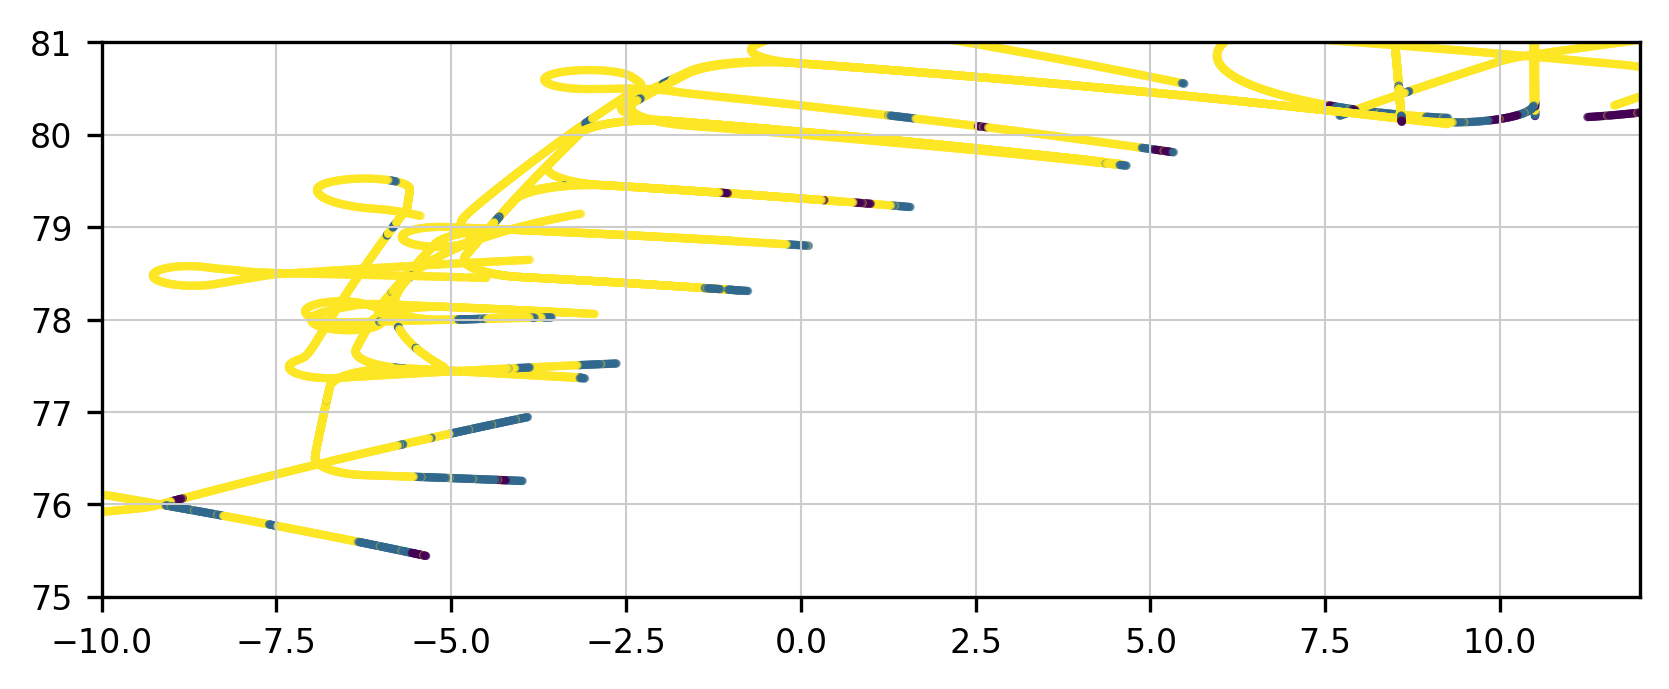

In [18]:
moc_per_time = histogram(pred_2d_all.label, dim=['x', 'y'], bins=bins).argmax(dim='label_bin').persist() 
x = pred_2d_all.lon
y = pred_2d_all.lat

fig, ax = plt.subplots()

ax.scatter(x, y, c=moc_per_time, s=1, alpha=.5)
ax.set_ylim(75, 81)
ax.set_xlim(-10, 12)

In [19]:
open_water = histogram(pred_2d_all.T_skin.where(pred_2d_all.label == 1), bins=np.linspace(-40, 0, 200), dim=['x', 'y'])#.sum(dim='time')
thick_ice = histogram(pred_2d_all.T_skin.where(pred_2d_all.label == 4), bins=np.linspace(-40, 0, 200), dim=['x', 'y'])#.sum(dim='time')
thin_ice = histogram(pred_2d_all.T_skin.where(pred_2d_all.label == 2), bins=np.linspace(-40, 0, 200), dim=['x', 'y'])#.sum(dim='time')



<xarray.DataArray 'histogram_T_skin' ()>
dask.array<truediv, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
<xarray.DataArray 'histogram_T_skin' ()>
dask.array<truediv, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
<xarray.DataArray 'histogram_T_skin' ()>
dask.array<truediv, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


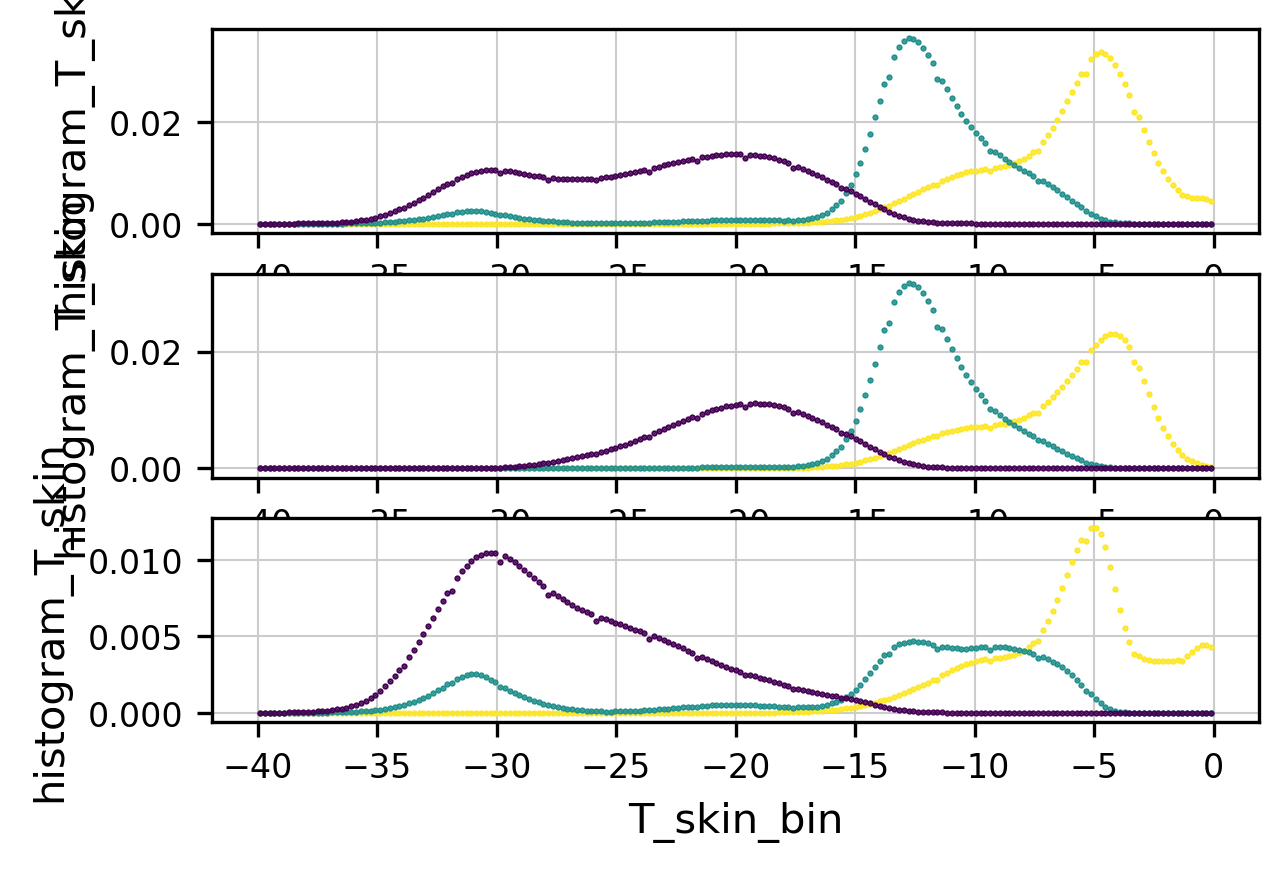

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(4.5, 3))

colors = plt.get_cmap('viridis_r')([0, .5, 1.5, 2.5, 4.5])
mask = (pred_2d_all.lat < 81) & (pred_2d_all.lon > -10) & (pred_2d_all.lon < 10)

for index, ds in enumerate([open_water, thin_ice, thick_ice]):

    N_tot = ds.sum()
    print(N_tot / 1e6)
    ds = ds / ds.sum()

    ds.sum(dim='time').plot(ax=axs[0], color=colors[index], marker='o', markersize=.5, lw=0)
    ds.isel(time=mask).sum(dim='time').plot(ax=axs[1], color=colors[index], marker='o', markersize=.5, lw=0)
    ds.isel(time=~mask).sum(dim='time').plot(ax=axs[2], color=colors[index], marker='o', markersize=.5, lw=0)


In [21]:
%matplotlib inline

In [22]:
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output


@widgets.interact(time=widgets.IntSlider(min=0, max=pred_2d_all.time.size-1, step=1, value=0))
def plot_map(time):
    clear_output(wait=True)

    #fig, ax = plt.gcf(), plt.gcf().get_axes()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    im = pred_2d_all.label.isel(time=time).plot.contourf(ax=ax[1], cmap='viridis', vmin=1, vmax=4, add_colorbar=False, levels=[0, 1, 2, 4])
    im2 = pred_2d_all.T_skin.isel(time=time).plot(ax=ax[0], cmap='plasma', vmin=-30, vmax=0, add_colorbar=False)
    ax[1].set_aspect('equal')
    ax[0].set_aspect('equal')
    cbar = fig.colorbar(im, ax=ax[1], fraction=0.05, pad=0.04)
    cbar.set_ticks([1, 2, 4])
    cbar.set_ticklabels(['Open Water', 'Thin Ice', 'Thick Ice'])
    cbar = fig.colorbar(im2, ax=ax[0], fraction=0.05, pad=0.04)
    cbar.set_label('T_skin [°C]')
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])    
    ax[1].set_title('')	
    fig.canvas.draw_idle()
    plt.show()





interactive(children=(IntSlider(value=0, description='time', max=48791), Output()), _dom_classes=('widget-inte…

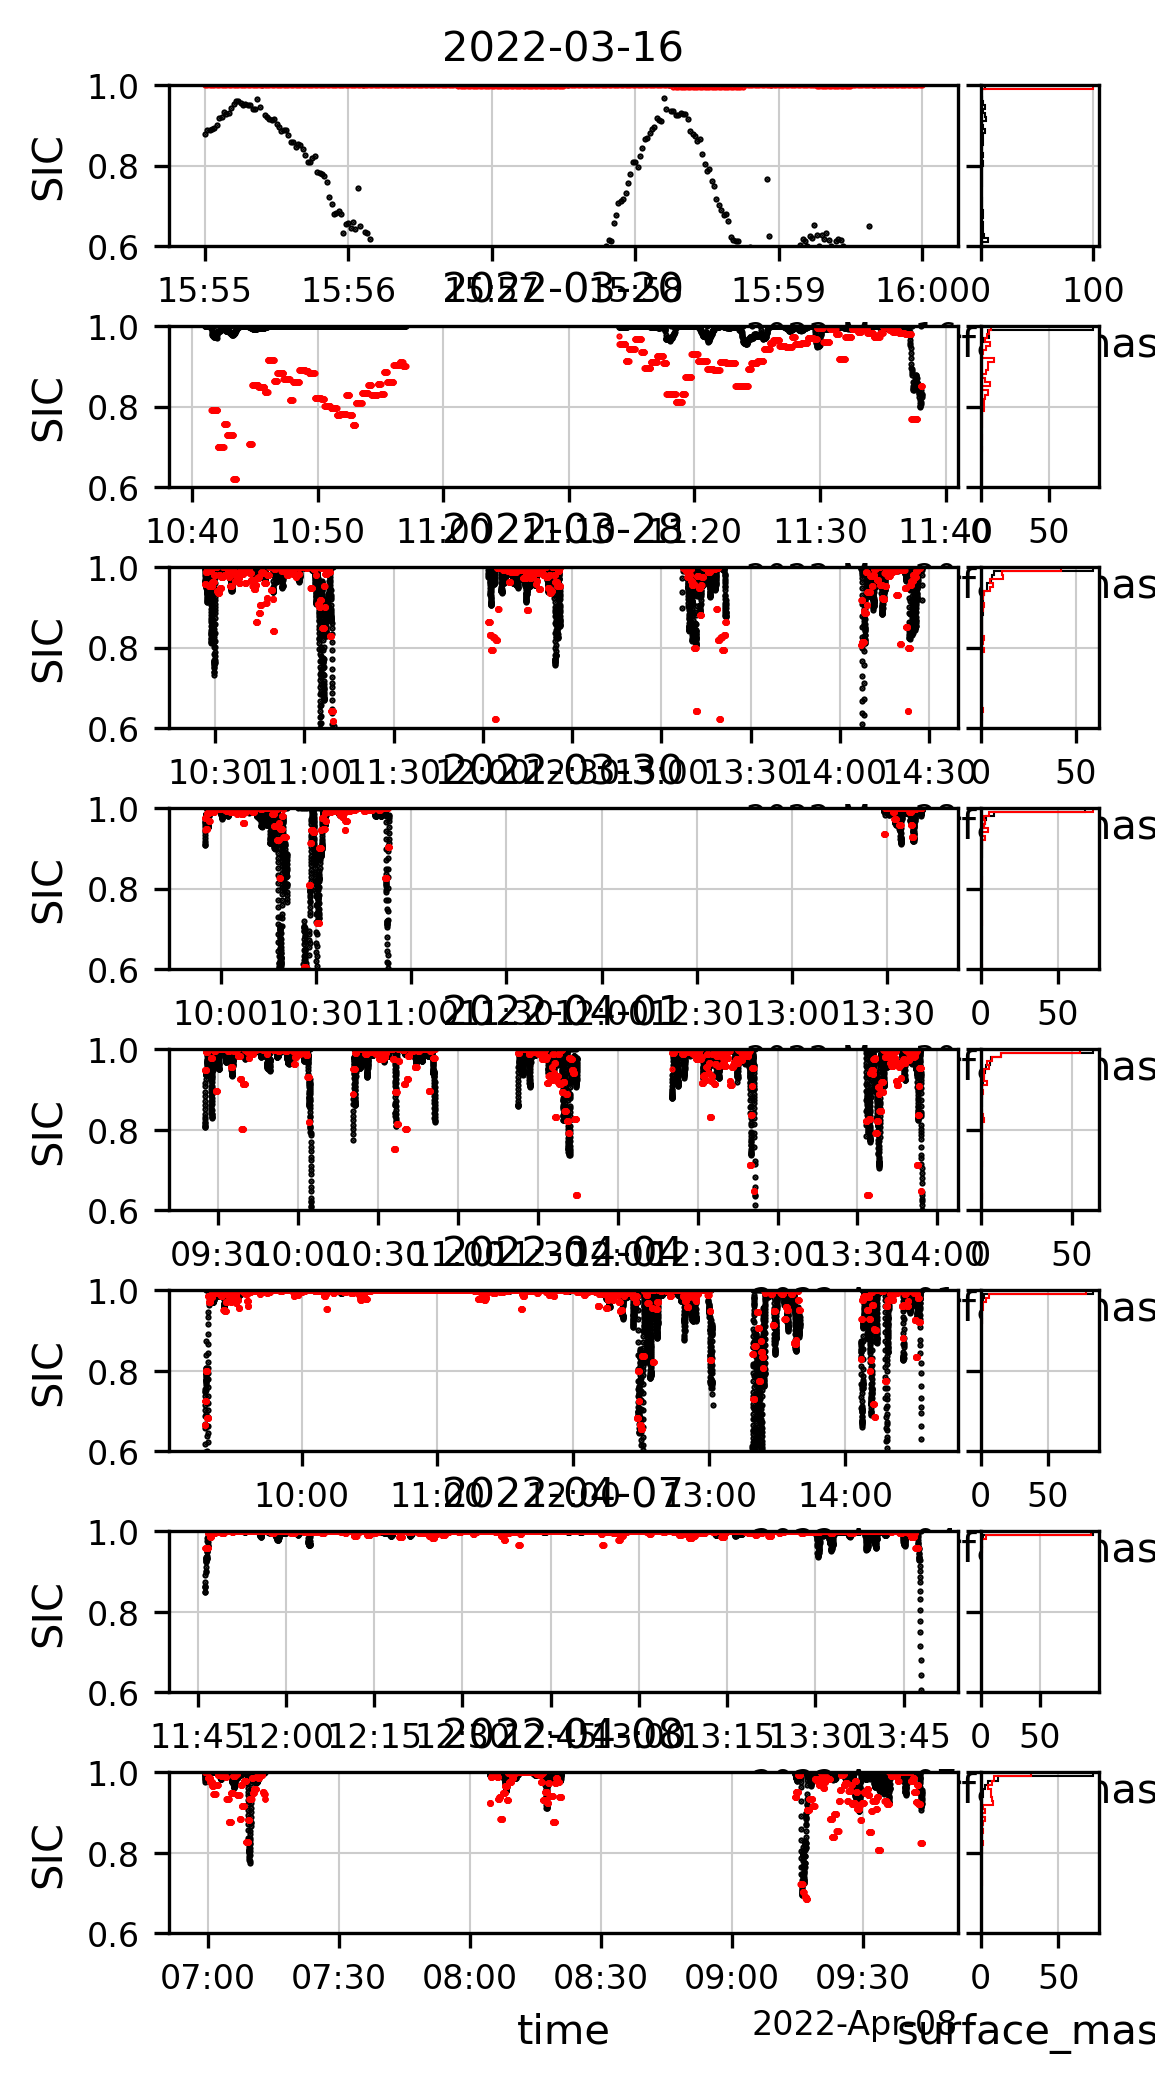

In [23]:
N, N_time = np.unique(pred_2d_all.time.dt.dayofyear, return_counts=True)

N_days = len(N)


fig, ax = plt.subplots(N_days, 2, figsize=(4, 1 * N_days),
    gridspec_kw={'hspace': 0.5, 'wspace': 0.05, 'width_ratios': [1, 0.15]},
    sharey=True)

for i, day in enumerate(N):
    pred_2d_all['sic'].isel(time=pred_2d_all.time.dt.dayofyear == day).plot(ax=ax[i, 0], marker='o', linestyle='', color='k', label='VELOX', markersize=.5)
    mira_subset['surface_mask'].isel(time=pred_2d_all.time.dt.dayofyear == day).plot(ax=ax[i, 0], marker='o', linestyle='', color='r', label='MIRA', markersize=.5)
    pred_2d_all['sic'].isel(time=pred_2d_all.time.dt.dayofyear == day).plot.hist(ax=ax[i, 1], bins=50, color='k', label='VELOX', range=(0.5, 1), histtype='step',  orientation='horizontal', density=True, lw=.5)
    mira_subset['surface_mask'].isel(time=pred_2d_all.time.dt.dayofyear == day).plot.hist(ax=ax[i, 1], bins=50, color='r', label='MIRA', range=(0.5, 1), histtype='step', orientation='horizontal', density=True, lw=.5)

    date = pd.to_datetime(pred_2d_all.time.isel(time=pred_2d_all.time.dt.dayofyear == day).values[0]).strftime('%Y-%m-%d')	

    ax[i, 0].set_title(date)
    ax[i, 0].set_ylim(0.6, 1)
    ax[i, 0].set_ylabel('SIC')



In [ ]:
x = ds_tb.lon.isel(band=0)
y = ds_tb.lat.isel(band=0)
c = ds_tb.isel(x=slice(317, 327), y=slice(247, 257)).surface_mask.mean(dim=['x', 'y'])

fig, ax = plt.subplots(1, figsize=(5, 4))

ax.scatter(x, y, c=c, cmap='viridis')
ax.set_xlabel('Longitude [°]')
ax.set_ylabel('Latitude [°]')

cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', alpha=0.7)
cbar.set_label('Sea ice type')

ax.set_ylim(76,81)
ax.set_xlim(-12, 12)


AttributeError: 'Dataset' object has no attribute 'surface_mask'

In [ ]:
637 // 2, 507 // 2

(318, 253)

In [ ]:
nadirs = []

for dist in [10, 25, 50, 100, 150, 200, 250]:

    nadir = ds_tb['skin_T'].isel(x=slice(318 - dist, 318 + dist), y=slice(253 - dist, 253 + dist)).mean(dim=['x', 'y'])
    nadirs.append(nadir)


KeyError: "No variable named 'skin_T'. Variables on the dataset include ['BT_2D', 'BT_Center', 'alt', 'lat', 'lon', 'time', 'yaw', 'sur_rgh', 'neighbor_mean', 'neighbor_std']"

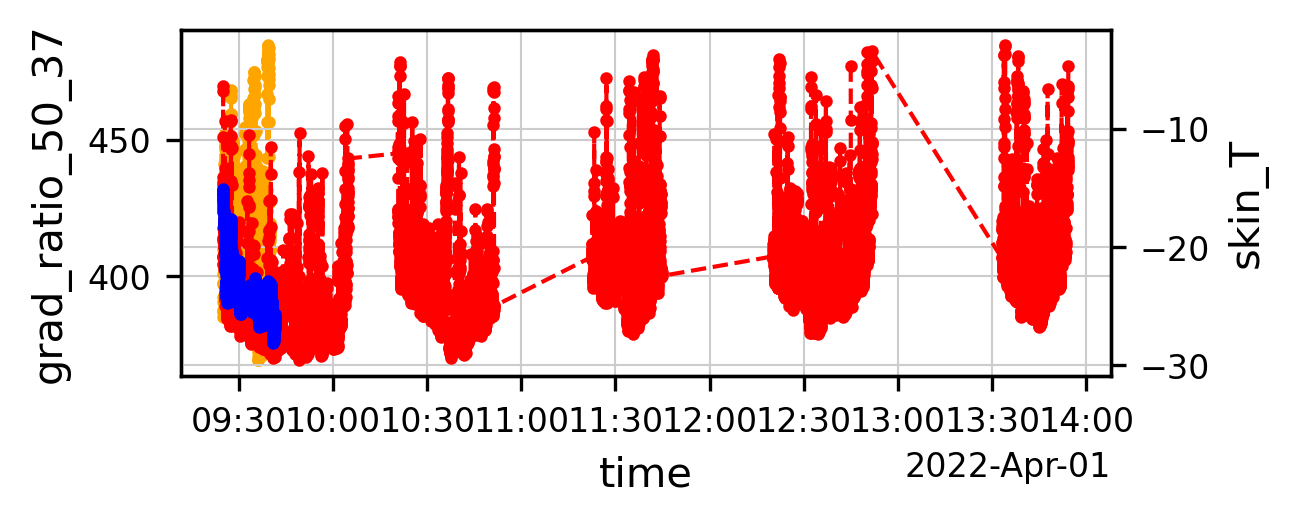

In [ ]:
fig, ax = plt.subplots(figsize=(4, 1.5))

mira_subset.grad_ratio_50_37.isel(time=slice(0, 1000)).plot(color='orange', lw=1, linestyle='--', markersize=2, marker='o')


ax1 = ax.twinx()



# try different central averages for the skin temperature

#for i, nadir in enumerate(nadirs):
#    nadir.plot(ax=ax1, lw=1, linestyle='--', markersize=2, marker='o')

nadirs[0].plot(ax=ax1, lw=1, linestyle='--', markersize=2, marker='o', color='r')


ds_tb['skin_T'].mean(dim=['x', 'y']).isel(time=slice(0, 1000)).plot(ax=ax1, color='b', lw=1, linestyle='--', markersize=2, marker='o')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


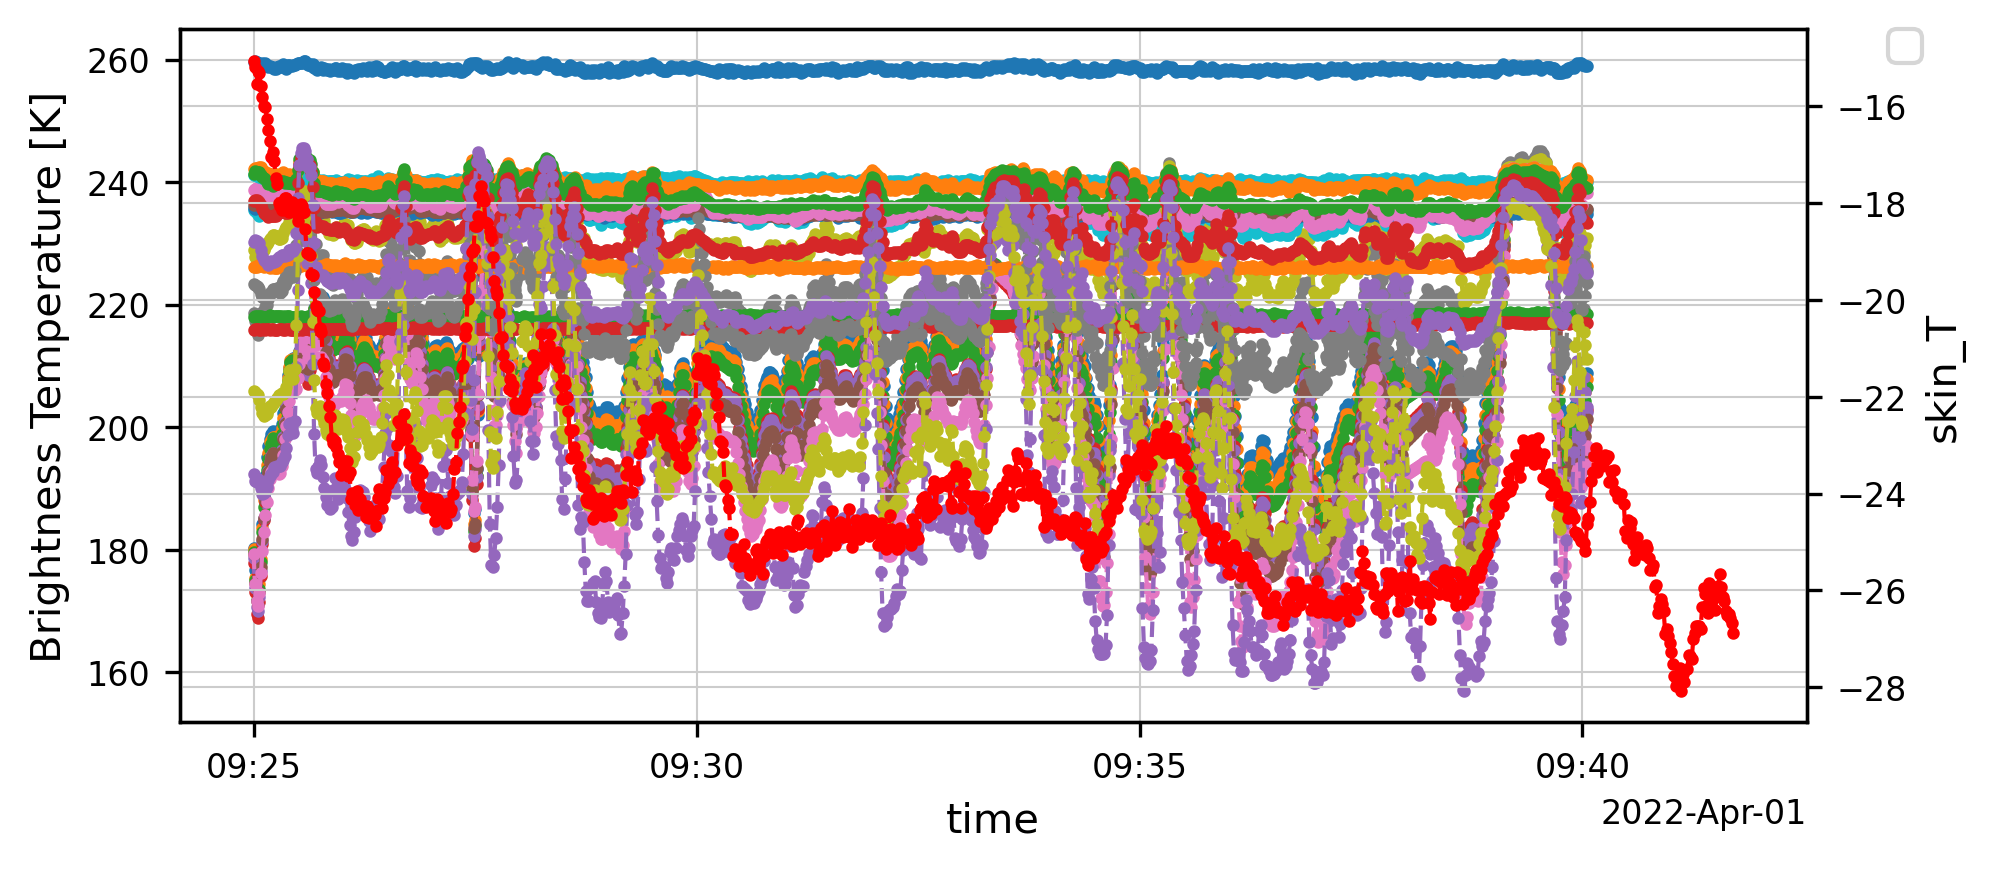

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))

mira_subset.TB.isel(time=slice(0, 1000)).plot(hue='uniRadiometer_freq',lw=1, linestyle='--', markersize=2, marker='o')

ax1 = ax.twinx()
ds_tb['skin_T'].mean(dim=['x', 'y']).isel(time=slice(0, 1000)).plot(ax=ax1, color='r', lw=1, linestyle='--', markersize=2, marker='o')


mira_subset

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

7it [00:15,  2.18s/it]


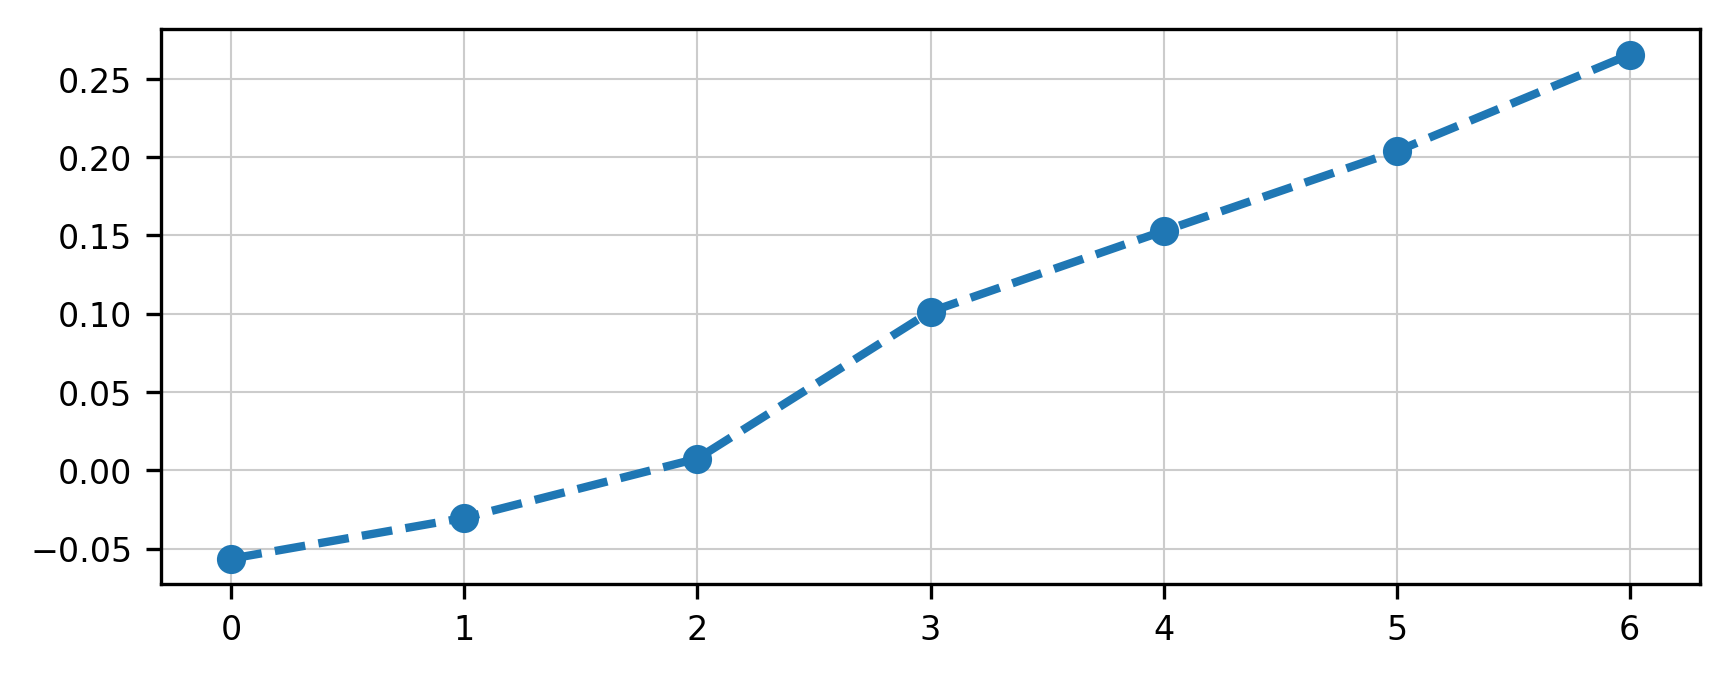

In [ ]:

from sklearn.metrics import r2_score
from scipy.stats import pearsonr    

correlations = []

nadir_skin_T = ds_tb['skin_T'].mean(dim=['x', 'y'])

for i, nadir_skin_T in tqdm(enumerate(nadirs)):

    x = mira_subset.TB.isel(uniRadiometer_freq=i).values
    y = nadir_skin_T.values

    mask = ~np.isnan(x) & ~np.isnan(y)

    x = x[mask]
    y = y[mask]



    #correlations.append(r2_score(x, y))
    correlations.append(pearsonr(x, y)[0])	

plt.plot(correlations, marker='o', linestyle='--')




In [ ]:
correlation_matrix.values

array([[-0.05641092, -0.0544872 , -0.04519255, -0.01230652,  0.0190807 ,
         0.03892535,  0.04624107],
       [-0.03314771, -0.03034125, -0.01987258,  0.01385262,  0.0444761 ,
         0.06305716,  0.06926495],
       [-0.00745296, -0.00383615,  0.00754231,  0.04100135,  0.06989404,
         0.08647712,  0.09106464],
       [ 0.05041038,  0.05585043,  0.06880612,  0.10137624,  0.1272627 ,
         0.14046676,  0.14221129],
       [ 0.07665594,  0.08287803,  0.09641378,  0.12836218,  0.1528689 ,
         0.16459487,  0.16511565],
       [ 0.12038116,  0.12781702,  0.14224865,  0.17296073,  0.19485392,
         0.20385384,  0.20214288],
       [ 0.19593242,  0.20551729,  0.22140868,  0.24953488,  0.26676051,
         0.27102098,  0.26553307],
       [ 0.37398097,  0.38818582,  0.4051752 ,  0.42423223,  0.42950659,
         0.42299373,  0.40929729],
       [ 0.39742662,  0.41234032,  0.43023646,  0.45067376,  0.45713907,
         0.45148458,  0.43833618],
       [ 0.48944987,  0.5076

/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


7 25


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Text(0, 0.5, 'Averaging distance from nadir [m]')

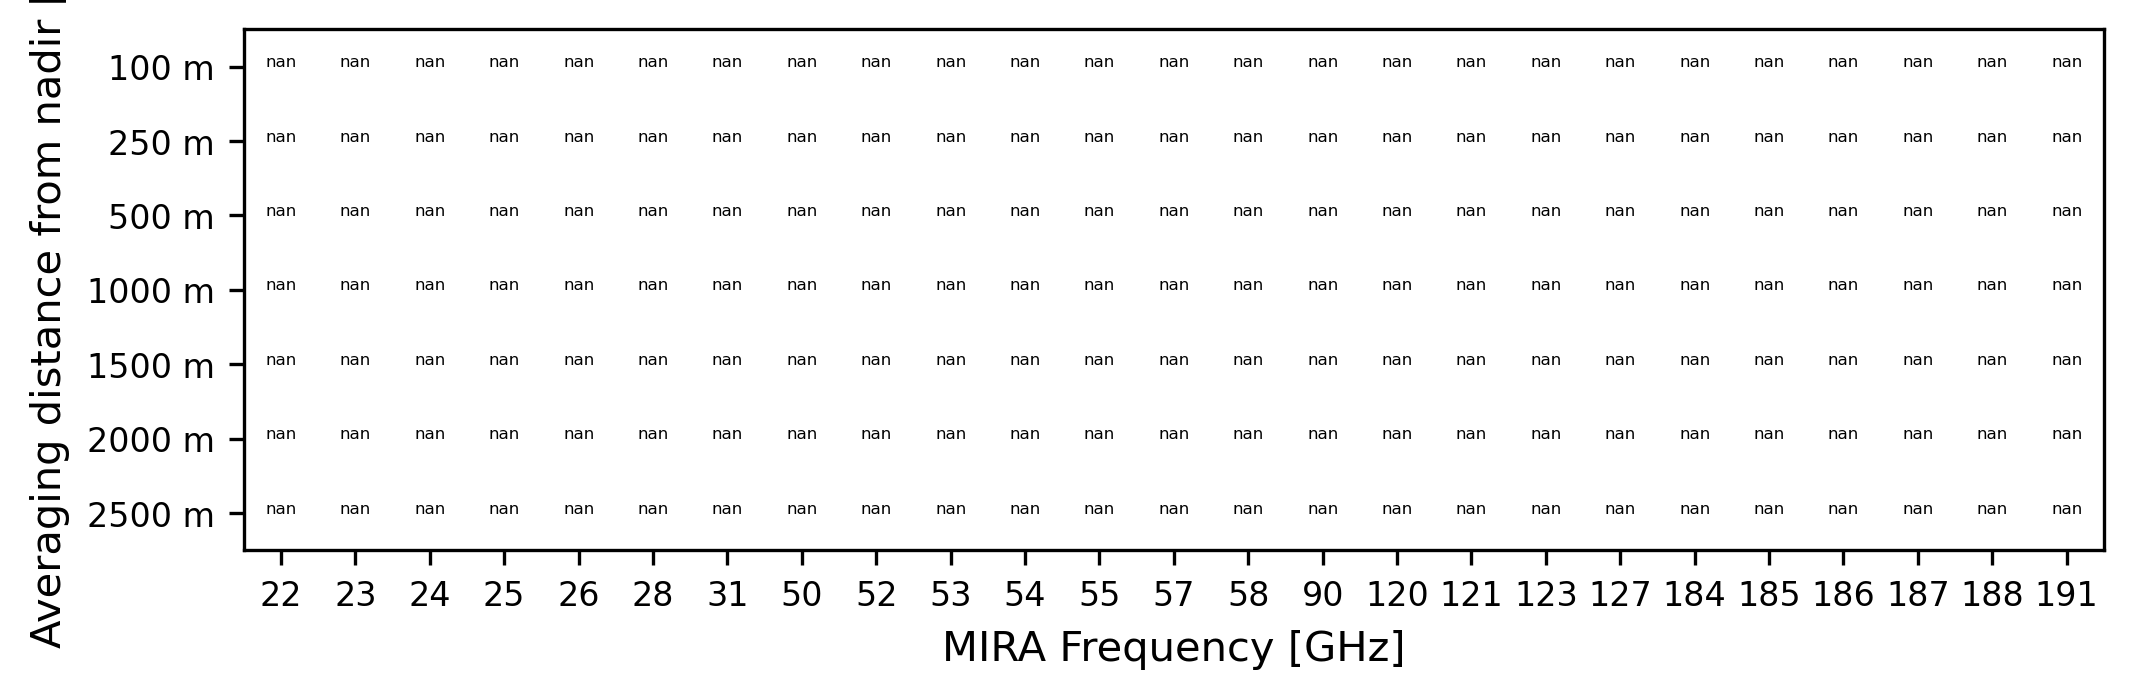

In [ ]:
#xr.corr(mira_subset.TB, xr.concat(nadirs, dim='dist'), dim='time')

### plot the numbers into the heatmap 

fig, ax = plt.subplots(figsize=(8, 4))


#tb_thermal_bands = ds_tb['BT_2D'].isel(x=slice(318 - 250, 318 + 250), y=slice(253 - 250, 253 + 250)).mean(dim=['x', 'y'])

correlation_matrix = xr.corr(mira_subset.TB, xr.concat(nadirs, dim='dist'), dim='time').persist()

data = correlation_matrix.values.T

im = ax.imshow(data, cmap='RdBu_r', vmin=-1, vmax=1)

# We want to show all ticks...
y_shape, x_shape = data.shape

print(y_shape, x_shape)

ax.set_xticks(np.arange(x_shape))
ax.set_yticks(np.arange(y_shape))

# ... and label them with the respective list entries

ax.set_yticklabels([f'{dist*10} m' for dist in [10, 25, 50, 100, 150, 200, 250]])
ax.set_xticklabels([f'{freq:.0f}' for freq in mira_subset.uniRadiometer_freq.values])

# Add the text
ax.axes.grid(False)

for i in range(y_shape):
    for j in range(x_shape):
        text = ax.text(j, i, f'{data[i, j]:.2f}',
                       ha="center", color="k", fontsize=4) 

ax.set_xlabel('MIRA Frequency [GHz]')

ax.set_ylabel('Averaging distance from nadir [m]')




KeyboardInterrupt: 

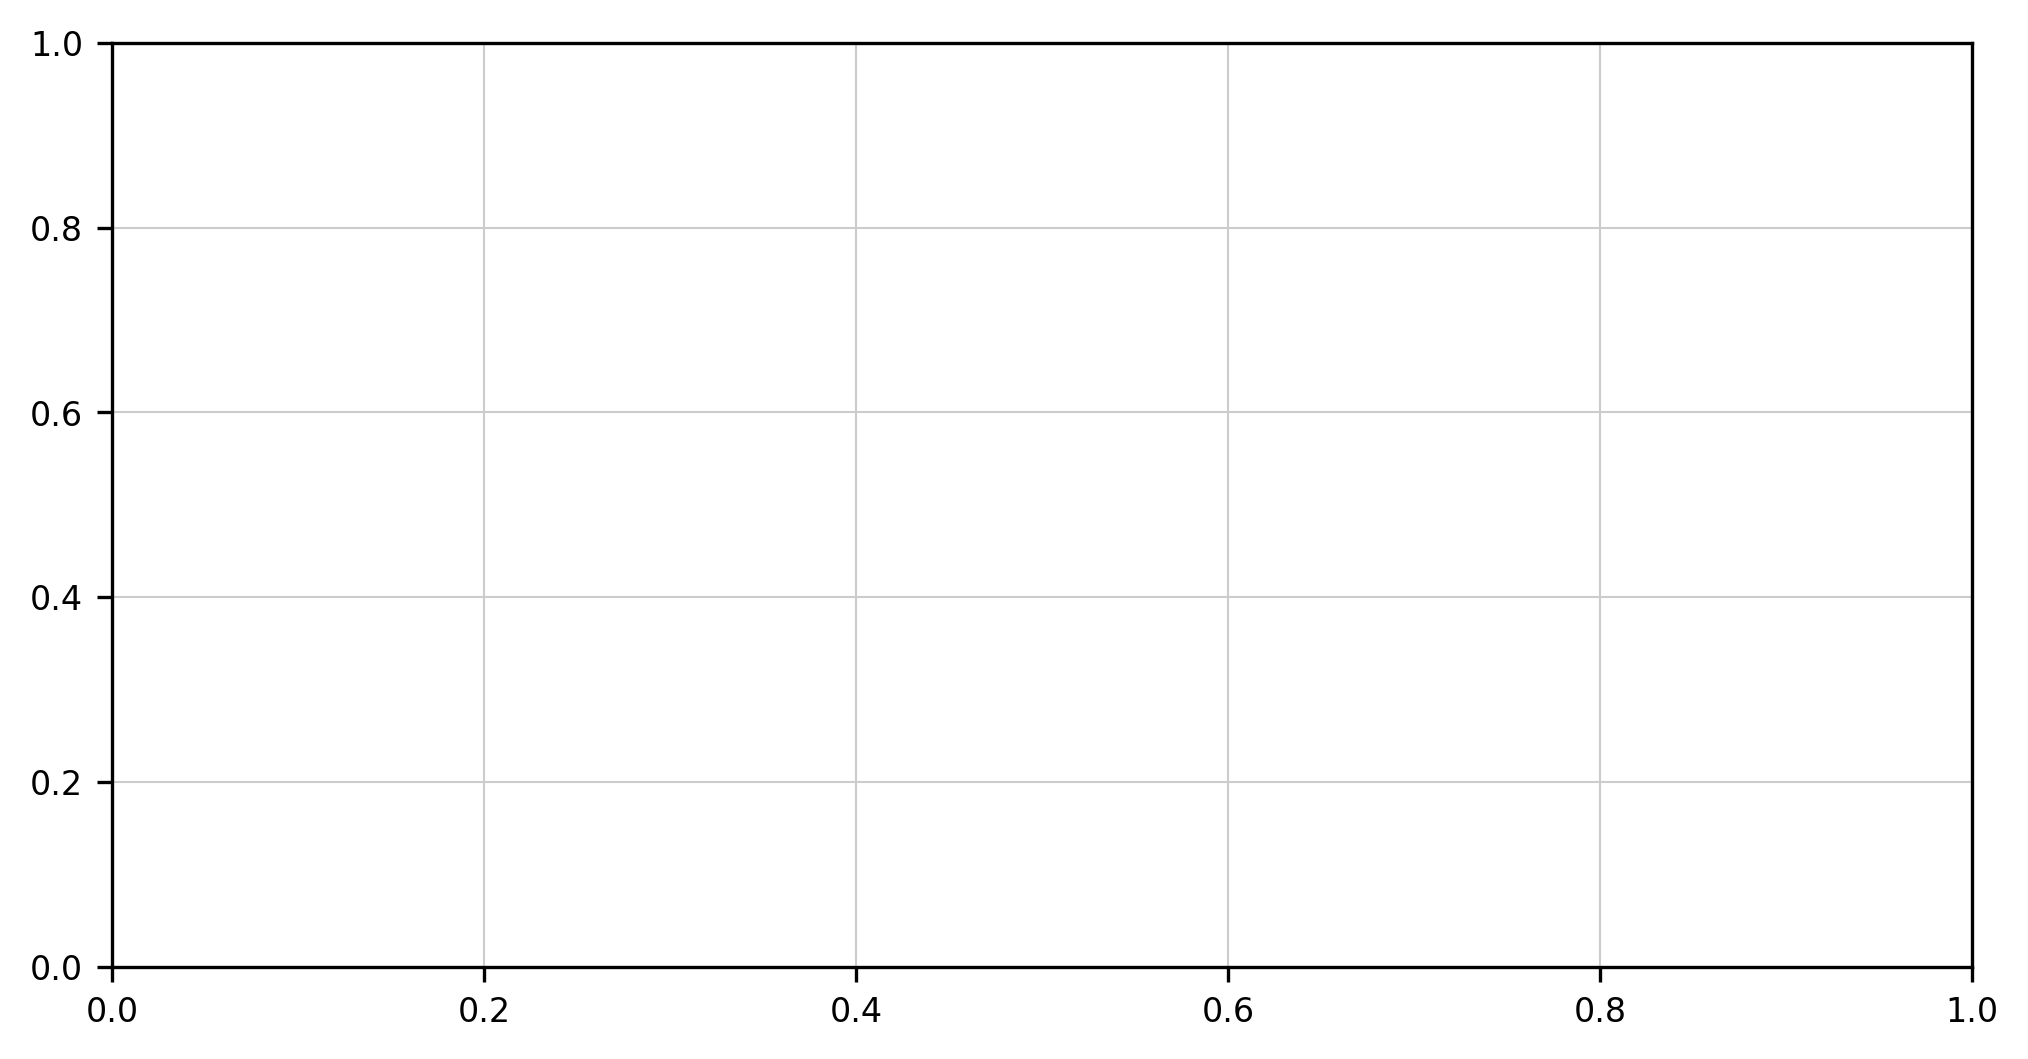

In [ ]:
#xr.corr(mira_subset.TB, xr.concat(nadirs, dim='dist'), dim='time')

### plot the numbers into the heatmap 

fig, ax = plt.subplots(figsize=(8, 4))


tb_thermal_bands = ds_tb['BT_2D'].isel(x=slice(318 - 250, 318 + 250), y=slice(253 - 250, 253 + 250)).mean(dim=['x', 'y'])

correlation_matrix = xr.corr(mira_subset.TB, tb_thermal_bands, dim='time').persist()

data = correlation_matrix.values.T

im = ax.imshow(data, cmap='RdBu_r', vmin=-1, vmax=1)

# We want to show all ticks...
y_shape, x_shape = data.shape

print(y_shape, x_shape)

ax.set_xticks(np.arange(x_shape))
ax.set_yticks(np.arange(y_shape))

# ... and label them with the respective list entries

ax.set_yticklabels([f'{band}' for band in [1, 2, 3, 5, 6]])
ax.set_xticklabels([f'{freq:.0f}' for freq in mira_subset.uniRadiometer_freq.values])

# Add the text
ax.axes.grid(False)

for i in range(y_shape):
    for j in range(x_shape):
        text = ax.text(j, i, f'{data[i, j]:.2f}',
                       ha="center", color="k", fontsize=4) 

ax.set_xlabel('MIRA Frequency [GHz]')

ax.set_ylabel('VELOX Band')




0it [00:00, ?it/s]

25it [01:14,  2.99s/it]


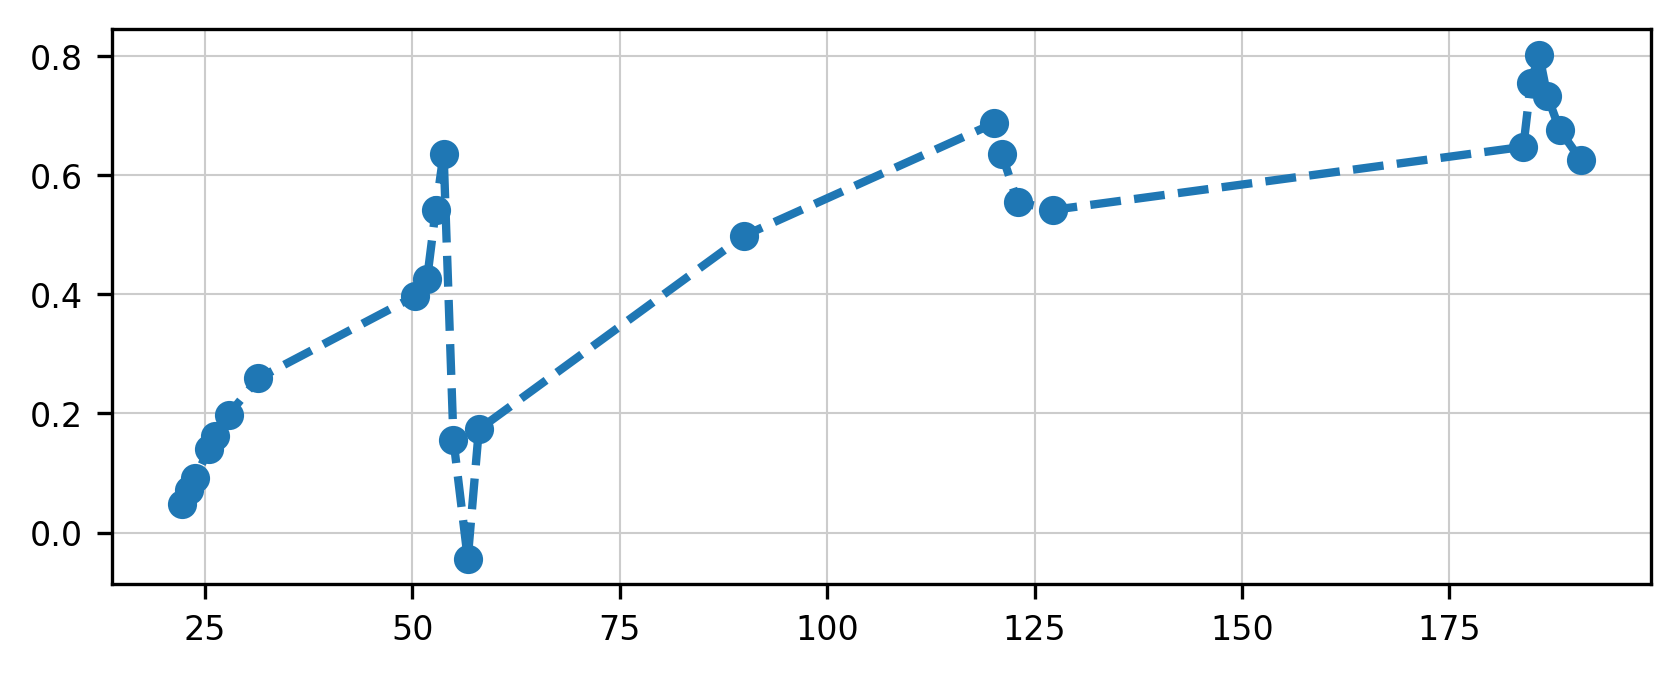

In [ ]:

from sklearn.metrics import r2_score
from scipy.stats import pearsonr    

correlations = []

nadir_skin_T = ds_tb['skin_T'].mean(dim=['x', 'y']),



for i, freq in tqdm(enumerate([nadirs])):

    x = mira_subset.TB.sel(uniRadiometer_freq=175, method='nearest').values
    y = nadir_skin_T.values

    mask = ~np.isnan(x) & ~np.isnan(y)

    x = x[mask]
    y = y[mask]



    #correlations.append(r2_score(x, y))
    correlations.append(pearsonr(x, y)[0])	

plt.plot(mira_subset.uniRadiometer_freq, correlations, marker='o', linestyle='--')




In [ ]:
correlations

[0.048431041883040996,
 0.07076789208938969,
 0.09148278755336307,
 0.14048774168096223,
 0.16256127641109974,
 0.19798053770753188,
 0.25877621529133055,
 0.3970286818206681,
 0.4260862759378518,
 0.541451249189859,
 0.6363253622725711,
 0.1549745568099256,
 -0.043762779016679736,
 0.17320950319249098,
 0.49867286076433903,
 0.6875338687313343,
 0.6351412701573546,
 0.5552484485202378,
 0.5418164729367725,
 0.6477173989097895,
 0.7555555892934748,
 0.8024457609578982,
 0.7326046399484021,
 0.6757405454350688,
 0.6262289522624391]

In [ ]:
correlations

[-304.6947492303084,
 -275.06366949766783,
 -253.12794527607673,
 -216.7402613050434,
 -206.5333094012281,
 -190.4798794209288,
 -155.99296093888205,
 -619.4209518550057,
 -1866.8450838238562,
 -10637.858948783376,
 -155945.26349059833,
 -261895.64726881406,
 -335460.1487716972,
 -286388.3659842223,
 -90.5065981890808,
 -62743.315242458135,
 -6517.149805822337,
 -506.7674559243774,
 -150.6484407019732,
 -73333.47845612047,
 -88919.92731945017,
 -16949.88881623396,
 -7872.044515274264,
 -2020.7462897012977,
 -631.6124282294761]

In [ ]:
correlation_coefficients

[nan, nan, nan, nan, nan, nan, nan]

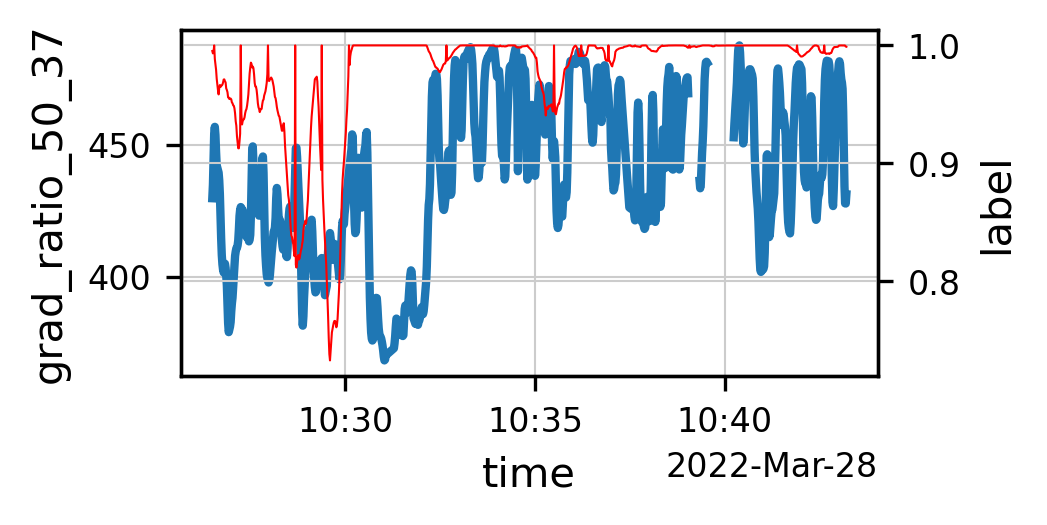

In [ ]:
fig, ax = plt.subplots(figsize=(3, 1.5))

mira_subset.grad_ratio_50_37.isel(time=slice(0, 1000)).plot()

ax1 = ax.twinx()
ds.label.isel(time=slice(0, 1000)).mean(dim=['x', 'y']).plot(ax=ax1, color='red', lw=0.5)